In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import numpy as np

# Classifiers tested
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Cross Validation
from sklearn.model_selection import cross_val_score, GridSearchCV

# Regression Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

import matplotlib.pyplot as plt
import seaborn as sns

# saving trained model with pickle
import pickle

# bespoke cleaning and data_split functions
from pre_processing import pre_processing, data_split

# Set seed for reproducibility
sd = 44

In [2]:
# Loading the data - with cleaned and pre-processed features for decision tree based classifiers
clean_data, feature_list = pre_processing('data/XYZCorp_LendingData.txt')
# Splitting the data and oversampling the training data set
X_train, X_test, y_train, y_test = data_split(clean_data, feature_list, random_split = False ,oversample = True)

In [3]:
len(X_train)

200000

### Decision Tree Classifier

In [7]:
dtc = DecisionTreeClassifier(random_state=sd)

params_dt = {'max_depth' : [None, 2,4,6],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf' : [1,2,5,10,50],
          'max_features' : ['sqrt', None],
          'class_weight' : ['balanced']}

# Instantiate a 5-fold CV grid search
dt_grid = GridSearchCV(estimator=dtc, 
                       param_grid=params_dt,
                       scoring='accuracy',
                       cv=5,
                       n_jobs=-1)

# Fit 'grid_dt' to the training data
dt_grid.fit(X_train, y_train)
best_dtc = dt_grid.best_estimator_
print('Best Hyperparameter values:\n',dt_grid.best_params_)
print('Best Decision Tree Classifier Score:\n',dt_grid.best_score_)

Best Hyperparameter values:
 {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Decision Tree Classifier Score:
 0.9954850000000001


In [16]:
# save the model to disk
filename = 'saved_models/classification/decision_tree_best_model.sav'
pickle.dump(best_dtc, open(filename, 'wb'))

0.9998132230311567


[[   300     11]
 [    37 256643]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256680
           1       0.89      0.96      0.93       311

    accuracy                           1.00    256991
   macro avg       0.95      0.98      0.96    256991
weighted avg       1.00      1.00      1.00    256991



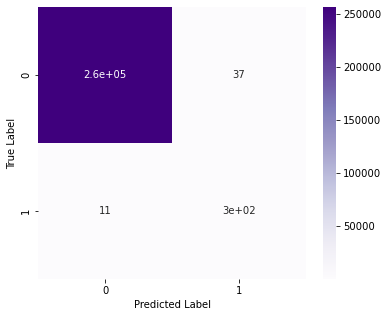

In [8]:
y_pred = best_dtc.predict(X_test)
print(confusion_matrix(y_test, y_pred,labels=[1,0]))
print(classification_report(y_test, y_pred))
cf_matrix1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
fig = sns.heatmap(cf_matrix1, annot=True, cmap='Purples')
plt.xlabel(("Predicted Label"))
plt.ylabel(("True Label"))
plt.show()

### Random Forest Classifier

In [9]:
rfc = RandomForestClassifier(n_jobs = -1, random_state=sd)

params_rf = {'n_estimators': [50, 100, 200, 400],
             'min_samples_split': [2, 5],
             'min_samples_leaf' : [1,2],
             'max_depth': [None, 10],
             'max_features': ['sqrt', None],
             'class_weight' : ['balanced']}

# Instantiate a 5-fold CV grid search
rf_grid = GridSearchCV(estimator=rfc, 
                       param_grid=params_rf,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1)

# Fit 'grid_dt' to the training data
rf_grid.fit(X_train, y_train)
best_rfc = rf_grid.best_estimator_
print('Best Hyperparameter values:\n',rf_grid.best_params_)
print('Best Random Forest Classifier score:\n',rf_grid.best_score_)

Best Hyperparameter values:
 {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best Random Forest Classifier score:
 0.9967279156547029


In [10]:
# printing all tested parameters
means = rf_grid.cv_results_['mean_test_score']
stds = rf_grid.cv_results_['std_test_score']
params = rf_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.995891 (0.003274) with: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.996294 (0.003055) with: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.996381 (0.002964) with: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.996356 (0.002973) with: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
0.995988 (0.003060) with: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.996210 (0.002947) with: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.9962

In [65]:
# save the model whole RF Gridto disk
filename = 'saved_models/classification/random_forest_cv_grid.sav'
pickle.dump(rf_grid, open(filename, 'wb'))

# save the best RF model to disk
filename = 'saved_models/classification/random_forest_best_classifier.sav'
pickle.dump(rf_grid.best_estimator_, open(filename, 'wb'))

[[   301     10]
 [    26 256654]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256680
           1       0.92      0.97      0.94       311

    accuracy                           1.00    256991
   macro avg       0.96      0.98      0.97    256991
weighted avg       1.00      1.00      1.00    256991



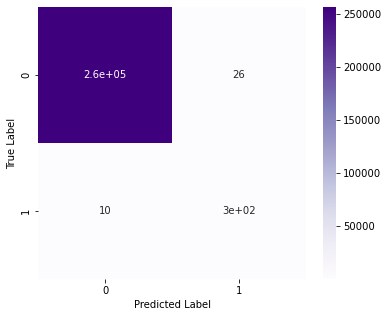

In [11]:
y_pred = best_rfc.predict(X_test)
print(confusion_matrix(y_test, y_pred,labels=[1,0]))
print(classification_report(y_test, y_pred))
cf_matrix1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
fig = sns.heatmap(cf_matrix1, annot=True, cmap='Purples')
plt.xlabel(("Predicted Label"))
plt.ylabel(("True Label"))
plt.show()

### XGBoost Classifier

In [24]:
xgb = XGBClassifier(random_state=sd)

params_xgb = {'learning_rate' : [0.4],
             'scale_pos_weight' : [(len(y_train)-y_train.sum())/y_train.sum()],
             'max_depth' : [5],
             'min_child_weight': [1],
             'n_estimators' : [80, 100, 150, 200, 250, 300, 400]}

# Instantiate a 5-fold CV grid search to find optimum number of trees (n_estimators)
xgb_grid = GridSearchCV(estimator=xgb, 
                       param_grid=params_xgb,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1)

# Fit 'grid_dt' to the training data
xgb_grid.fit(X_train, y_train)
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))
means = xgb_grid.cv_results_['mean_test_score']
stds = xgb_grid.cv_results_['std_test_score']
params = xgb_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print('Increasing over 200 trees gives little benefit')

C:\Users\DE7\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.998108 using {'learning_rate': 0.4, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'scale_pos_weight': 1.0}
0.997862 (0.002061) with: {'learning_rate': 0.4, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 80, 'scale_pos_weight': 1.0}
0.997957 (0.001965) with: {'learning_rate': 0.4, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1.0}
0.998063 (0.001853) with: {'learning_rate': 0.4, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150, 'scale_pos_weight': 1.0}
0.998098 (0.001838) with: {'learning_rate': 0.4, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.998068 (0.001881) with: 

In [34]:
# Tuning max_depth and min_child_weight with set n_estimators
params_xgb = {'learning_rate' : [0.4],
              'scale_pos_weight' : [(len(y_train)-y_train.sum())/y_train.sum()],
              'max_depth':[3, 5, 7, 9],
              'min_child_weight':[1,3,5,7],
              'n_estimators' : [200],             
}

xgb_grid = GridSearchCV(estimator=xgb, 
                       param_grid=params_xgb,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1)

xgb_grid.fit(X_train, y_train)
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))
means = xgb_grid.cv_results_['mean_test_score']
stds = xgb_grid.cv_results_['std_test_score']
params = xgb_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("'max_depth': 9, 'min_child_weight': 3 give best results") 

C:\Users\DE7\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:39:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.998129 using {'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.997680 (0.002195) with: {'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.997705 (0.002295) with: {'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.997610 (0.002333) with: {'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.997530 (0.002310) with: {'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.998098 (0.001838) with:

In [35]:
# Tuning gamma
params_xgb = {'learning_rate' : [0.4],
              'scale_pos_weight' : [(len(y_train)-y_train.sum())/y_train.sum()],
              'max_depth':[9],
              'min_child_weight':[3],
              'n_estimators' : [200],
              'gamma' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}

xgb_grid = GridSearchCV(estimator=xgb, 
                       param_grid=params_xgb,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1)

xgb_grid.fit(X_train, y_train)
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))
means = xgb_grid.cv_results_['mean_test_score']
stds = xgb_grid.cv_results_['std_test_score']
params = xgb_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print('Gamma equal to 0.4 yields best results')

C:\Users\DE7\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:08:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.998180 using {'gamma': 0.4, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.998129 (0.001709) with: {'gamma': 0.0, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.998129 (0.001607) with: {'gamma': 0.1, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.998129 (0.001577) with: {'gamma': 0.2, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0}
0.998069 (0.001599) with: {'gamma': 0.3, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, '

In [36]:
# Tuning subsample & colsample_bytree
params_xgb = {'learning_rate' : [0.4],
              'scale_pos_weight' : [(len(y_train)-y_train.sum())/y_train.sum()],
              'max_depth':[9],
              'min_child_weight':[3],
              'n_estimators' : [200],
              'gamma' : [0.0],
              'subsample':[0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1.0]}

xgb_grid = GridSearchCV(estimator=xgb, 
                       param_grid=params_xgb,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1)

xgb_grid.fit(X_train, y_train)
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))
means = xgb_grid.cv_results_['mean_test_score']
stds = xgb_grid.cv_results_['std_test_score']
params = xgb_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print('subsample & colsample_bytree equal to 1.0 yields best results')

C:\Users\DE7\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:28:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.998194 using {'colsample_bytree': 0.9, 'gamma': 0.0, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 1.0}
0.997646 (0.002120) with: {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.6}
0.997711 (0.002228) with: {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.7}
0.997857 (0.002021) with: {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight'

In [43]:
# Tuning the learning rate
params_xgb = {'learning_rate' : [0.1,0.15,0.2,0.25,0.3, 0.35, 0.4, 0.45, 0.5],
              'scale_pos_weight' : [(len(y_train)-y_train.sum())/y_train.sum()],
              'max_depth':[9],
              'min_child_weight':[3],
              'n_estimators' : [200],
              'gamma' : [0.0,0.4],
              'subsample':[1.0],
              'colsample_bytree':[1.0]}

xgb_grid = GridSearchCV(estimator=xgb, 
                       param_grid=params_xgb,
                       scoring='f1',
                       cv=5,
                       n_jobs=-1)

xgb_grid.fit(X_train, y_train)
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))
means = xgb_grid.cv_results_['mean_test_score']
stds = xgb_grid.cv_results_['std_test_score']
params = xgb_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print('learning rate equal to 0.4 yields best results')

C:\Users\DE7\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:02:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.998180 using {'colsample_bytree': 1.0, 'gamma': 0.4, 'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 1.0}
0.998094 (0.001537) with: {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 1.0}
0.998170 (0.001505) with: {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 1.0}
0.998139 (0.001625) with: {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight

In [60]:
xgb = XGBClassifier(colsample_bytree= 1.0,
                    gamma= 0.0,
                    learning_rate= 0.15,
                    max_depth= 9,
                    min_child_weight= 3,
                    n_estimators= 200,
                    scale_pos_weight= 1.0,
                    subsample= 1.0,
                    random_state=sd)

xgb.fit(X_train, y_train)

C:\Users\DE7\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=44, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[   301     10]
 [    27 256653]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256680
           1       0.92      0.97      0.94       311

    accuracy                           1.00    256991
   macro avg       0.96      0.98      0.97    256991
weighted avg       1.00      1.00      1.00    256991



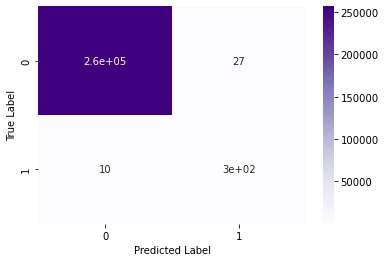

In [61]:
y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred,labels=[1,0]))
print(classification_report(y_test, y_pred))
cf_matrix1 = confusion_matrix(y_test, y_pred)


fig = sns.heatmap(cf_matrix1, annot=True, cmap='Purples')
plt.xlabel(("Predicted Label"))
plt.ylabel(("True Label"))
plt.show()

In [62]:
# save the xgboost grid to disk
filename = 'saved_models/classification/gxboost_cv_grid.sav'
pickle.dump(xgb_grid, open(filename, 'wb'))

# save the best gxboost model to disk
filename = 'saved_models/classification/gxboost_best.sav'
pickle.dump(xgb, open(filename, 'wb'))

In [ ]:

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.best_estimator_.score(X_test, y_test)
print(result)

In [70]:
# Load individual classifiers
best_dtc = pickle.load(open('saved_models/classification/decision_tree_best_model.sav', 'rb'))
best_rfc = pickle.load(open('saved_models/classification/random_forest_best_classifier.sav', 'rb'))
best_xgb = pickle.load(open('saved_models/classification/gxboost_best.sav', 'rb'))


classifiers = [('Classification Tree', best_dtc),
               ('Random Forest', best_rfc),
               ('GXBoost', best_xgb)]


for clf_name, clf in classifiers:
    y_pred = clf.predict(X_test)
    print('{:s} : {:.6f}'.format(clf_name, accuracy_score(y_test, y_pred)))

Classification Tree     : 0.999813
Random Forest     : 0.999860
GXBoost     : 0.999856


In [71]:
# Instantiate a VotingClassifier 'vc'
vc = VotingClassifier(estimators=classifiers) 
# Fit 'vc' to the traing set and predict test set labels
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
# Evaluate the test-set accuracy of 'vc'
print('Voting Classifier: {:.6f}'.format(accuracy_score(y_test, y_pred)))


C:\Users\DE7\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Voting Classifier: 0.999868


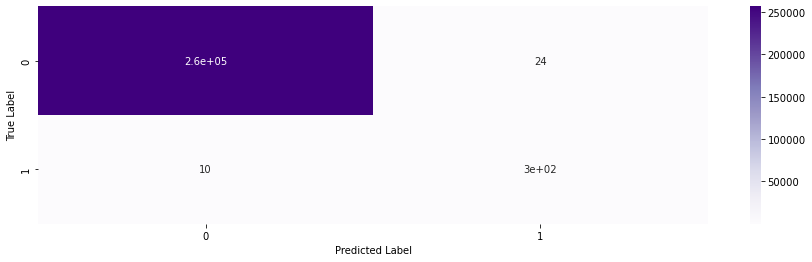

In [72]:
cf_matrix1 = confusion_matrix(y_test, y_pred)


fig = sns.heatmap(cf_matrix1, annot=True, cmap='Purples')
plt.xlabel(("Predicted Label"))
plt.ylabel(("True Label"))
plt.show()

In [75]:
# save the voting classifier model to disk
filename = 'saved_models/classification/voting_classfier.sav'
pickle.dump(vc, open(filename, 'wb'))

In [78]:
# Saving common test data for all classifiers
X_test.to_csv('classification_test_data/X_test.csv', sep = '|')
pd.DataFrame(y_test).to_csv('classification_test_data/y_test.csv', sep = '|')